In [1]:
from PIL import Image
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

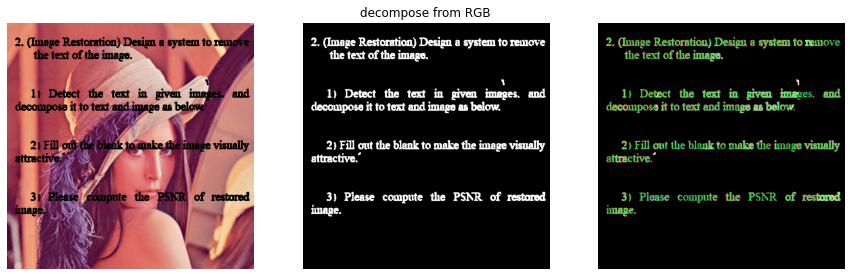

In [2]:
# 1) Detect the text in given images, and decompose them to the text and image.

ground_truth = Image.open('Image/lena.bmp')
ground_truth = np.array(ground_truth)  

img = Image.open('lena(18).bmp')
img = np.array(img)  # RGB

def morphology(img, k): # dilate
    h,w = img.shape
    newimg = np.zeros((h,w),dtype='uint8')
    offset = len(k) // 2
    for i in range(offset, h-offset):
        for j in range(offset, w-offset):
            if(img[i][j]==255):
                newimg[i-offset:i+offset+1,j-offset:j+offset+1] = np.bitwise_or(img[i-offset:i+offset+1, \
                                                              j-offset:j+offset+1], k)
    return newimg

threshold = 230
text_mask = img[:,:,1].copy()  # green channel
text_mask[text_mask[:,:]>threshold] = 255
text_mask[text_mask[:,:]<threshold] = 0

#size = 3
#k = np.full((size,size),255, dtype='uint8')
#text_mask = morphology(text_mask, k)

k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
text_mask = cv2.dilate(text_mask, k)
img_result = cv2.bitwise_and(img, img, mask = ~text_mask) 

h,w = img.shape[:2]
img_result = np.zeros((h,w,3), dtype='uint8')
text = np.zeros((h,w,3), dtype='uint8')
img_result[:,:,0] = np.multiply(img[:,:,0], ~text_mask // 255) 
img_result[:,:,1] = np.multiply(img[:,:,1], ~text_mask // 255) 
img_result[:,:,2] = np.multiply(img[:,:,2], ~text_mask // 255) 
text[:,:,0] = np.multiply(img[:,:,0],text_mask // 255)
text[:,:,1] = np.multiply(img[:,:,1],text_mask // 255)
text[:,:,2] = np.multiply(img[:,:,2],text_mask // 255)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img_result.astype('uint8'))
plt.subplot(1,3,2)
plt.axis('off')
plt.title('decompose from RGB')
plt.imshow(text_mask, cmap = 'gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(text)

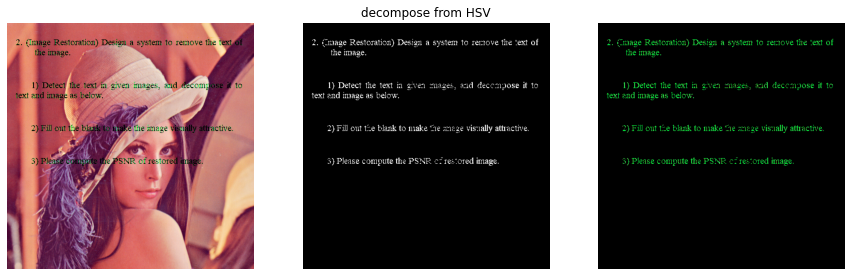

In [3]:
img = Image.open('lena(14).bmp')
img = np.array(img)  # RGB
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
lower_blue = (60-10, 30, 30) 
upper_blue = (60+10, 255, 255) 
text_mask = cv2.inRange(img_hsv, lower_blue, upper_blue) 
text = cv2.bitwise_and(img, img, mask = text_mask)
img_result = cv2.bitwise_and(img, img, mask = ~text_mask)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img_result)
plt.subplot(1,3,2)
plt.axis('off')
plt.title('decompose from HSV')
plt.imshow(text_mask, cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(text)

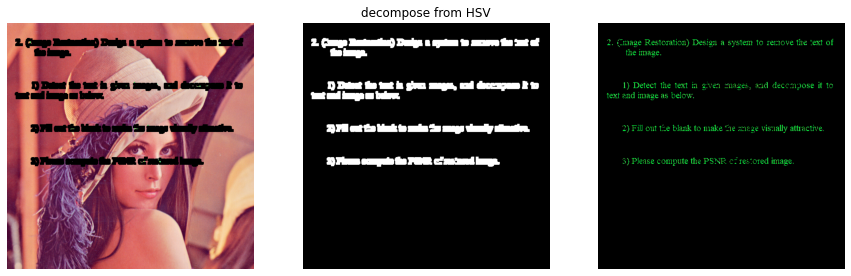

In [4]:
k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
text_mask = cv2.dilate(text_mask, k)
text_mask = cv2.dilate(text_mask, k)
img_result = cv2.bitwise_and(img, img, mask = ~text_mask) 

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img_result)
plt.subplot(1,3,2)
plt.axis('off')
plt.title('decompose from HSV')
plt.imshow(text_mask, cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(text)

In [5]:
#2) Fill out the blank to make the image visually attractive.

restoredImgCV2 = cv2.inpaint(img_result.astype('uint8'),text_mask,3,cv2.INPAINT_TELEA)

In [6]:
def inpaintImage(img,x,y, kernel):
    h,w = img.shape
    ksize = len(kernel) // 2
    if 1 > ksize or x> w-ksize or ksize > y or y>h-ksize:
        return 
    if img[x,y]!=0:
        return
    
    offset = len(kernel) // 2
    subImage = img[x-offset:x+offset+1,y-offset:y+offset+1].copy()
    nonZeroR = subImage.copy()
    nonZeroR[nonZeroR!=0]=1
    nonZeroR = nonZeroR * kernel
    nonZeroR = nonZeroR / nonZeroR.sum()
    value = (subImage * nonZeroR).sum()
    
    img[x,y] = value

    inpaintImage(img, x+1,   y,  kernel)
    inpaintImage(img, x+1, y+1,  kernel)
    inpaintImage(img,   x, y+1,  kernel)
    inpaintImage(img, x-1, y+1, kernel)
    inpaintImage(img, x-1,   y, kernel)
    inpaintImage(img, x-1, y-1, kernel)
    inpaintImage(img,   x, y-1,  kernel)
    inpaintImage(img, x+1, y-1, kernel)

def BoxFilter(size):
    kernel = np.ones((size,size))
    kernel = kernel / kernel.size
    return kernel

def gaussianFilter(size, std):
    kernel = np.zeros((size,size))
    offset= size//2
    for i in range(-offset,offset+1):
        for j in range(-offset,offset+1):
            kernel[i+offset][j+offset] = math.exp( -1 * ( i**2 + j**2 ) / (2*(3**2)) )
    return kernel / kernel.sum()

h,w = img_result.shape[:2]
kernel1 = BoxFilter(3)
kernel2 = gaussianFilter(3, 3)
restoredImg = img_result.copy()
for i in range(1,h-1):
    for j in range(1,w-1):
        if restoredImg[i,j,0]==0:
            inpaintImage(restoredImg[:,:,0], i, j, kernel2)
        if restoredImg[i,j,1]==0:
            inpaintImage(restoredImg[:,:,1], i, j, kernel2)
        if restoredImg[i,j,2]==0:
            inpaintImage(restoredImg[:,:,2], i, j,  kernel2)

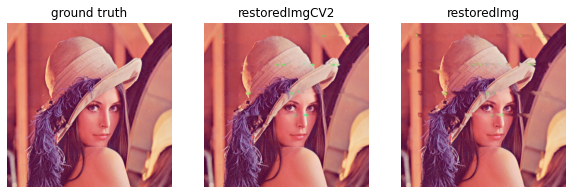

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title('ground truth')
plt.axis('off')
plt.imshow(ground_truth)
plt.subplot(1,3,2)
plt.axis('off')
plt.title('restoredImgCV2')
plt.imshow(restoredImgCV2)
plt.subplot(1,3,3)
plt.axis('off')
plt.title('restoredImg')
plt.imshow(restoredImg)

In [8]:
#3) Please compute the PSNR of restored image.
def PSNR(img1, img2):
    mse = ((img1-img2)**2).mean()
    psnr = 10*math.log10(255**2 / mse )
    return psnr

print('restored Image(OpenCV) VS Ground-Truth: ', PSNR(ground_truth,restoredImgCV2))
print('restored Image(my_method) VS Ground-Truth: ', PSNR(ground_truth,restoredImg))

restored Image(OpenCV) VS Ground-Truth:  41.475894493900924
restored Image(my_method) VS Ground-Truth:  40.391221511649206
